скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention  
там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
сделать разбиение набора данных не тренировочную и тестовую выборки  
сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)  
провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 
  1) и вариант с двумя независимыми моделями  
в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей  
построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево  
(опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift:
 1) сделать прогноз и получить uplift для тестовой выборки   
2) отсортировать тестовую выборку по uplift по убыванию   
3) разбить на децили (pandas qcut вам в помощь)    
 4) для каждого дециля посчитать среднюю conversion  
(опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево  

# Чтение Данных

https://drive.google.com/file/d/1A9bZkjMfvE2TZyOtYoTdPKWlYd38wLDb/view?usp=sharing

In [123]:
! gdown --id 1A9bZkjMfvE2TZyOtYoTdPKWlYd38wLDb

Downloading...
From: https://drive.google.com/uc?id=1A9bZkjMfvE2TZyOtYoTdPKWlYd38wLDb
To: /content/data.csv
2.68MB [00:00, 76.1MB/s]


In [124]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
df = pd.read_csv('/content/data.csv', delimiter=',')

In [126]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [127]:
df.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'offer', 'conversion'],
      dtype='object')

# Работа с Данными

## Переименование Колонок

In [128]:
df.rename(columns={'conversion': 'target'}, inplace=True)
df.rename(columns={'offer': 'treatment'}, inplace=True)

In [129]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [130]:
dict_treatment = {'No Offer': 0, 'Discount': 1, 'Buy One Get One':1}

In [131]:
df['treatment'] = df['treatment'].map(dict_treatment)

In [132]:
indices_train = df.index
indices_test = df.index

## Деление на Train, Test

In [133]:
indices_learn, indices_valid = train_test_split(df.index, test_size=0.2, random_state=123)

In [134]:
indices_learn.shape

(51200,)

## Выделение целевых переменных

In [135]:
df_train = df[['treatment', 'target']]
# df_treatment = df['treatment']
# df_target = df['target']
df.drop(['treatment', 'target'], inplace=True, axis=1)

In [136]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web
3,9,675.83,1,0,Rural,1,Web
4,2,45.34,1,0,Urban,0,Web
...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web
63996,5,38.91,0,1,Urban,1,Phone
63997,6,29.99,1,0,Urban,1,Phone
63998,1,552.94,1,0,Surburban,1,Multichannel


In [137]:
df_transform = df['history'].values
df_transform

array([142.44, 329.08, 180.65, ...,  29.99, 552.94, 472.82])

## Стандартизация колонки history и recency

In [138]:
df['history'] = df['history']/df['history'].max()
# df['recency'] = df['recency']/df['recency'].max() # стандартизация этой колонки не влияет на конечный результат

In [139]:
df['recency'].unique()

array([10,  6,  7,  9,  2,  1,  5,  4,  3, 11, 12,  8])

In [140]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,0.042571,1,0,Surburban,0,Phone
1,6,0.098352,1,1,Rural,1,Web
2,7,0.053991,0,1,Surburban,1,Web
3,9,0.201986,1,0,Rural,1,Web
4,2,0.013551,1,0,Urban,0,Web


In [141]:
X_train = df.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

X_test = df.loc[indices_train, :]


CAT_FEATURE_NAMES = [i for i in df.describe(include= 'object').columns]
cat_features = CAT_FEATURE_NAMES

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%': [],
    'uplift@10%': []
}

# Обудение на модели SoloModel

In [142]:
!pip install scikit-uplift

In [143]:
!pip install catboost

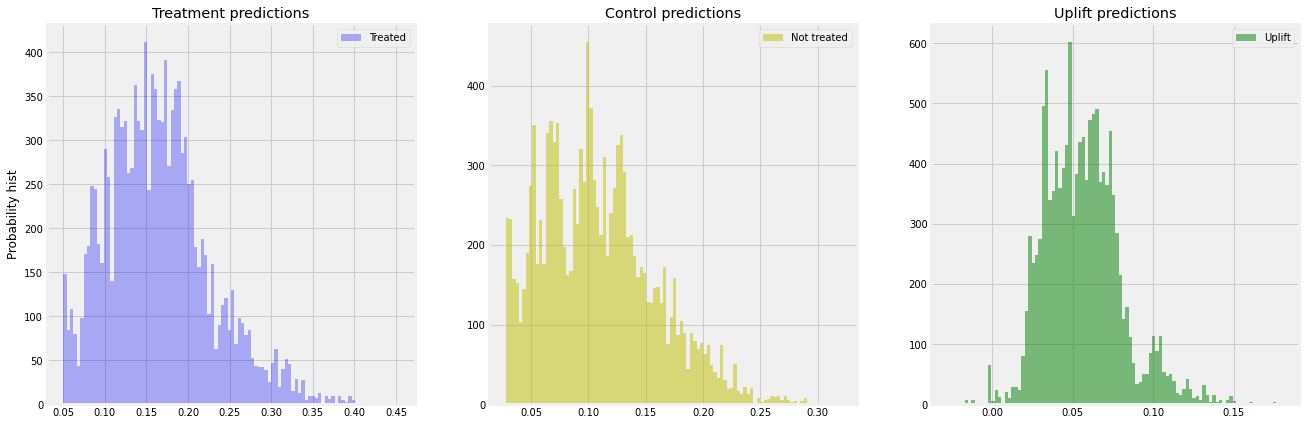

In [144]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score_30)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@10%'].append(sm_score_10)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

## посмотрим на важность признаков

In [145]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.043019
1,treatment,18.447217
2,used_bogo,13.786856
3,channel,11.338633
4,used_discount,10.045228
5,zip_code,9.983161
6,recency,8.891315
7,history,7.464570


# Обучение через TwoModels

In [146]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score_30)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@10%'].append(ct_score_10)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


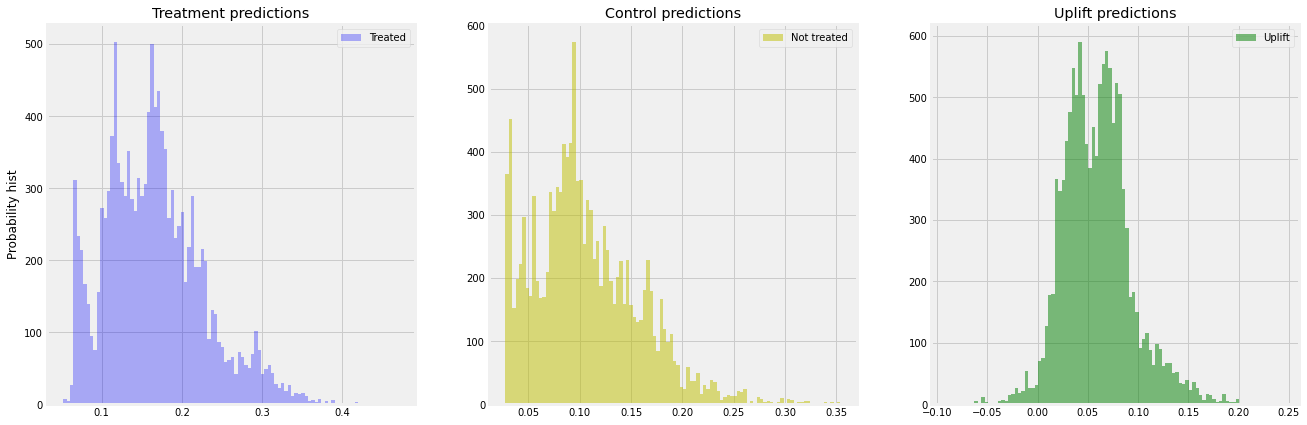

In [147]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score_30)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@10%'].append(tm_score_10)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

# Посмотрим на результаты моделей в сравнении

In [148]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift@20%,uplift@10%
1,ClassTransformation,0.079961,0.096156,0.096651
2,TwoModels,0.076733,0.082026,0.069639
0,SoloModel,0.074444,0.078538,0.097764


# Построене через модель дерева решений

## обрабатываю категориальные признаки т.к. дерево само их обработать не может

In [149]:
!pip install causalml

In [150]:
X_train_tree = pd.concat([X_train, pd.get_dummies(X_train[[i for i in cat_features]])], axis=1)

In [151]:
cat_features

['zip_code', 'channel']

In [152]:
X_train_tree.drop(['zip_code', 'channel'], 1, inplace=True)

In [153]:
features = [col for col in X_train_tree]
features

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

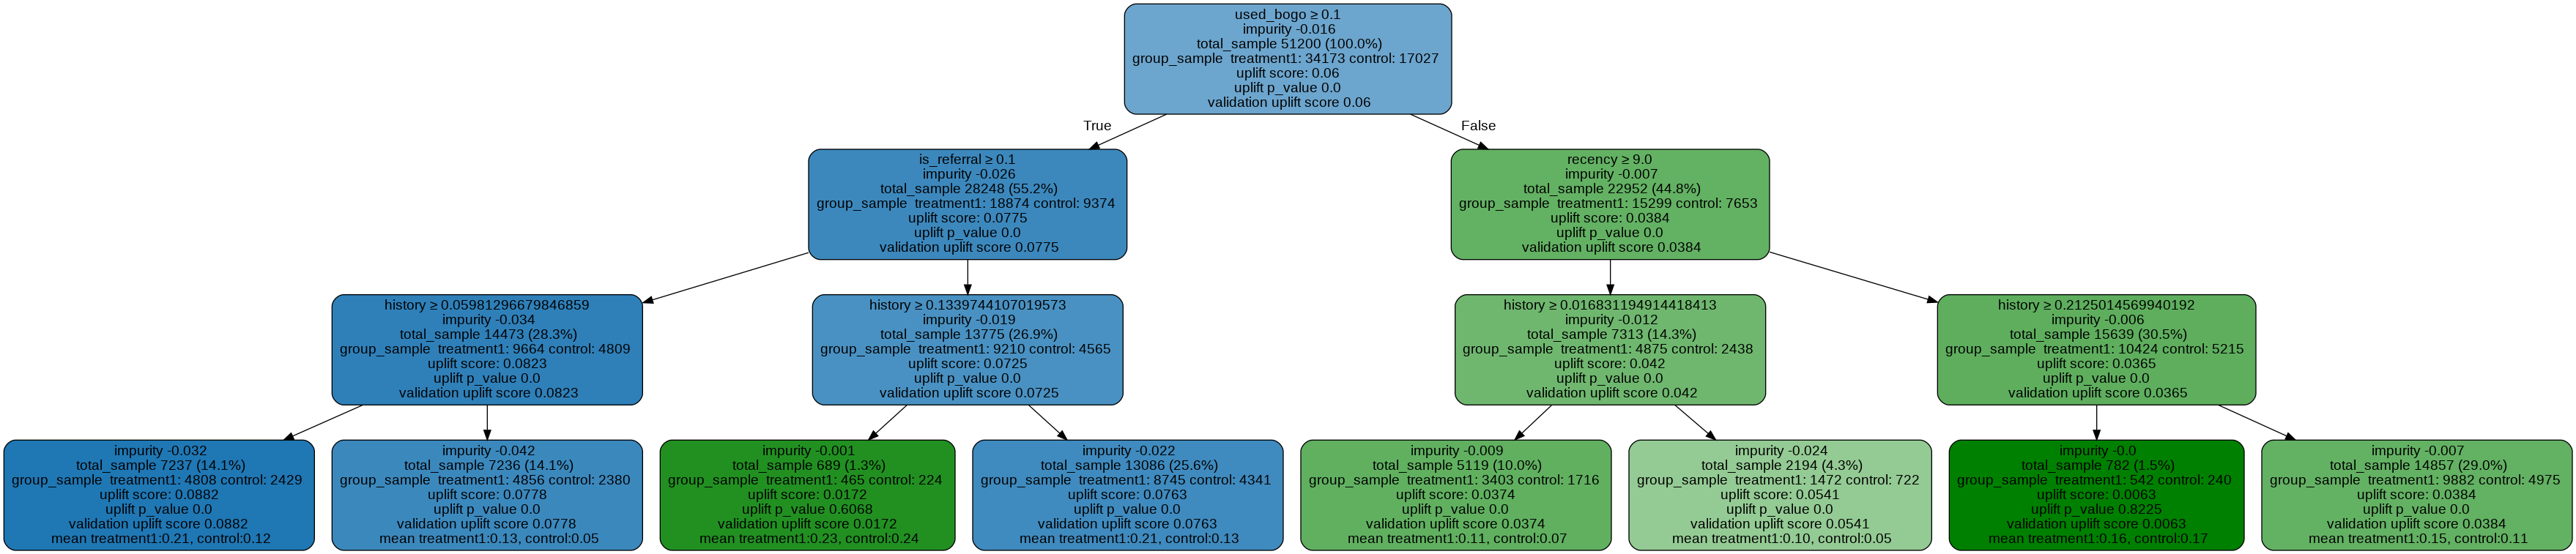

CPU times: user 2.36 s, sys: 56.2 ms, total: 2.42 s
Wall time: 2.61 s


In [156]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

# Вывод

если used_bogo больше 0.1, is_referral < 0.1, history < 0.13 uplift хороший  
так же uplift не плохой везде где used_bogo < 0.1